# **1-Layer-SNN**
Encodes the data in a process, then sends it to a Dense Layer where all the processing layers will be contained.

### Importing modules

In [1]:
#import modules

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import logging

In [2]:
#lava modules
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.model.sub.model import AbstractSubProcessModel
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.resources import CPU
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.process.variable import Var
from lava.proc.dense.process import Dense

#spikingFT
import run_sft
import spikingFT.models.snn
import spikingFT.utils.ft_utils

Intel NxSDK cannot be found. It will not be possible to run simulations with Loihi
Intel NxSDK cannot be found. It will not be possible to run simulations with Loihi


### Creating processes
Two Processes: one with an OutPort, one with an InPort and OutPort

In [3]:
class P1(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (32,))
        bias = kwargs.pop("bias", 0)
        vth = kwargs.pop("vth", 10)
        
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)

        self.u = Var(shape=shape, init=0)
        self.v = Var(shape=shape, init=0)
        self.spiked = Var(shape=shape, init=0)
        self.acc_spikes = Var(shape=shape, init=0)
        self.time_spiked = Var(shape=shape, init=0)
        self.tspk = Var(shape=shape, init=0)
        self.k = Var(shape=shape, init=0)
        self.bias = Var(shape=shape, init=bias)
        self.vth = Var(shape=(1,), init=vth)
 
class P2(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get('shape', (32,))

        self.inp2 = InPort(shape=shape)
        self.s_out2 = OutPort(shape=(30,))

        self.time_spiked2 = Var(shape=(30,), init=0)
        self.v_membrane = Var(shape=shape, init=0)
        self.i_real = Var(shape=shape, init=0)
        self.i_imag = Var(shape=shape, init=0)
        self.v_real = Var(shape=shape, init=0)
        self.v_imag = Var(shape=shape, init=0)
        self.stacked = Var(shape=(30,), init=0)
        self.stacked2 = Var(shape=(30,), init=0)
        self.spiked2 = Var(shape=(30,), init=0)
        self.acc_spikes2 =  Var(shape=(30,), init=0)


### Creating processes models

In [4]:

#PyProcModel implementing P1
@implements(proc=P1, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyLifModel1(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float, precision=24)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    spiked: np.ndarray = LavaPyType(np.ndarray, float)
    acc_spikes: np.ndarray = LavaPyType(np.ndarray, float)
    time_spiked: np.ndarray = LavaPyType(np.ndarray, float)
    bias: np.ndarray = LavaPyType(np.ndarray, float)
    tspk: np.ndarray = LavaPyType(np.ndarray, float)
    k: np.ndarray = LavaPyType(np.ndarray, float)
    vth: float = LavaPyType(float, float)
    
    def run_spk(self):
        #sine function (from 0 to 2*pi; 32 samples)
        nsamples=32
        x = np.linspace(0, 2*np.pi, nsamples)
        plt.plot(x, np.sin(x))


        plt.xlabel('Angle [rad]')
        plt.ylabel('sin(x)')
        plt.axis('tight')
        plt.show()
        a_in_data=np.sin(x)
        self.u=a_in_data

        #Calculates the slope
        if(self.time_step==1):
            m=(1-num_steps_per_input)/(np.max(self.u)-np.min(self.u))
            b=1-m*np.max(self.u)

            for index2 in range(len(self.u)):
                self.tspk[index2] =m*self.u[index2]+b
                self.k[index2] = (vth/self.tspk[index2])-self.u[index2]

        #Keeps adding up until the spiked is produced.
        for index in range(len(self.v)):
            if (self.acc_spikes[index]<1):
                self.v[index] += self.u[index]+self.k[index]

        # Check if the threshold is reached.
        s_out = self.v>= self.vth
        self.spiked[:]=s_out

        #Variable to save spikes (to keep the voltage = 0 after neuron spiked)
        self.acc_spikes+=self.spiked
        
        #Saves time at the spike is produced.
        self.time_spiked[s_out]=self.time_step

        # Reset voltage to 0 (Refactory period).
        self.v[s_out] = 0 

        # Sends spike.
        self.s_out.send(self.spiked)


#PyProcModel implementing P2
@implements(proc=P2, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyProcModelC(PyLoihiProcessModel):
    inp2: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out2: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float, precision=24)
    time_spiked2: np.ndarray = LavaPyType(np.ndarray, float)
    v_membrane: np.ndarray = LavaPyType(np.ndarray, float)
    i_real: np.ndarray = LavaPyType(np.ndarray, float)
    i_imag: np.ndarray = LavaPyType(np.ndarray, float)
    v_real: np.ndarray = LavaPyType(np.ndarray, float)
    v_imag: np.ndarray = LavaPyType(np.ndarray, float)
    stacked2: np.ndarray = LavaPyType(np.ndarray, float)
    stacked: np.ndarray = LavaPyType(np.ndarray, float)
    acc_spikes2: np.ndarray = LavaPyType(np.ndarray, float)
    spiked2: np.ndarray = LavaPyType(np.ndarray, float)
    
    def run_spk(self):
        in_data1 = self.inp2.recv()
        sim_time=num_steps_per_input
        nsamples=32
        
        #Getting weight arrays
        re_weights, im_weights = spikingFT.utils.ft_utils.dft_connection_matrix(
            nsamples,
            "numpy"
            )

        k_real = np.dot(re_weights, in_data1.transpose())
        k_imag = np.dot(im_weights, in_data1.transpose())

        self.i_real+=k_real
        self.i_imag+=k_imag

        #Getting weight arrays  
        self.v_real+=self.i_real
        self.v_imag+=self.i_imag

        #Simulation time reaches Ts
        if(self.time_step==num_steps_per_input):

            #Getting rid of offset and negative spectrum.
            sft_real = self.v_real[1:int(nsamples/2)]
            sft_imag = self.v_imag[1:int(nsamples/2)]

            # Max possible voltage during charging stage is the zero-mode intensity
            # for a wave containing a flat x_max divided by two.
            self.v_threshold =np.sum(re_weights[0,:]) * num_steps_per_input / 4

            #Calculating current to add up at each time step.
            i_spiking=2*self.v_threshold/num_steps_per_input
            
            self.stacked=np.hstack([sft_real, sft_imag])
            self.stacked2=np.hstack([sft_real, sft_imag])



            #Until simulation time reaches 2*Ts
            while(sim_time<=2*num_steps_per_input):

                #Keeps adding up until the spiked is produced.
                for index5 in range(len(self.stacked)):
                    if (self.acc_spikes2[index5]<1):
                        self.stacked[index5] += i_spiking

                # Check if the threshold is reached.
                s_out2 = self.stacked>= self.v_threshold

                self.spiked2[:]=s_out2

                #Variable to save spikes (to keep the voltage = 0 after neuron spiked).
                self.acc_spikes2+=self.spiked2
                
                # Reset voltage to 0 (Refactory period).
                self.stacked[s_out2] = 0 

                #Time step at which the threshold is reached by each neuron.
                self.time_spiked2[s_out2]=sim_time

                sim_time+=1

                # Sends spike.
                self.s_out2.send(self.stacked)

                #Plotting.
                if(sim_time==2*num_steps_per_input):
                    print("\nInputs: \n{}\n".format(self.stacked2))
                    print("\nSpiking times: \n{}\n".format(self.time_spiked2))
                    plt.plot(self.time_spiked2,self.stacked2,'ro')
                    plt.xlabel("Time (steps)")
                    plt.ylabel("Inputs (voltage)")
                    plt.title('Spiking time')
                    plt.show()



### Containing process
It will be where all the layer-processes will be contained

In [5]:
class ContainingProcess(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (32, ))
        self.s_in = InPort(shape=shape)
        self.s_out = OutPort(shape=(30, ))

### Containing process model

In [6]:
@implements(proc=ContainingProcess, protocol=LoihiProtocol)
class ContainingProcessModel(AbstractSubProcessModel):
    def __init__(self, proc):
        self.p1 = P1()
        self.p2 = P2()

        # connect in-port of the containing process to the in-port of the first process (inside containing process).
        proc.in_ports.s_in.connect(self.p2.inp2)
        # connect last-process output (inside containing process) to the output of the containing process.
        self.p2.s_out2.connect(proc.out_ports.s_out)


### Running the SNN

In [7]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps



Inputs: 
[ 3.68236308e-02 -3.83191361e-03 -2.44603481e-03 -1.26259103e-03
 -3.29065628e-03 -3.30340179e-03 -2.25137484e-03 -3.51212346e-16
 -5.20913607e-03 -2.55597321e-03 -2.72704618e-03 -2.64365897e-03
 -3.05871378e-03 -2.02746139e-03 -2.21566885e-03 -3.74853160e-01
  1.43548194e-02  9.04005863e-03  5.40579483e-03  5.17982239e-03
  3.48236109e-03  3.71987068e-03  9.76562500e-04  3.29846499e-03
  1.05532850e-03  2.43419905e-03  1.49954483e-03 -4.87118201e-05
  2.09036787e-04  1.19478683e-03]


Spiking times: 
[72. 75. 75. 75. 75. 75. 75. 75. 75. 75. 75. 75. 75. 75. 75. 98. 74. 74.
 74. 74. 74. 74. 74. 74. 74. 74. 74. 75. 74. 74.]



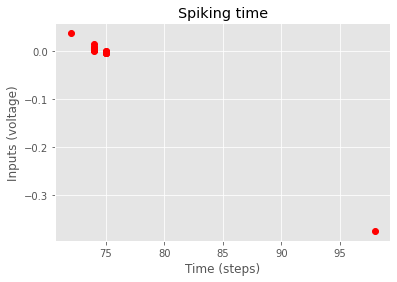

In [8]:
num_steps_per_input = 50 #steps
vth=5
step=1
bias=0
shape=(32,) #shape
sender1 = P1(shape=shape, bias=bias,num_steps=num_steps_per_input, vth=vth)
sender2 = ContainingProcess()

# Connecting output port to an input port (of the containing process).
sender1.s_out.connect(sender2.s_in)

sender2.run(RunSteps(num_steps=num_steps_per_input), Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True))